In [1]:
!pip install transformers datasets scikit-learn --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import os, time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [4]:
# Load dataset
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipython-input-4-1827933523.py:2: ParserWarning: Skipping line 195029: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
/tmp/ipython-input-4-1827933523.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)


In [5]:
df = df.sample(15000)

In [6]:
df['label'].value_counts()

,count
label,
1,12664
0,2336


In [7]:
# Step 4: Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)


In [8]:
# Step 5: Tokenize with XLM-RoBERTa
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [9]:
# Step 6: Format as Dataset object
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [10]:
# Step 7: Load the XLM-RoBERTa model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Step 8: Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [14]:
# Step 9: Set up Trainer
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/XLM-RoBERTa_Sentiment/results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/XLM-RoBERTa_Sentiment/logs',
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [15]:
start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Evaluation
start_test = time.time()
predictions = trainer.predict(val_dataset)
test_time = time.time() - start_test

y_pred = predictions.predictions.argmax(axis=-1)
y_true = val_labels[:len(y_pred)]

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")

# Step 11: Evaluate the model
eval_result = trainer.evaluate()
print(eval_result)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.212000,0.197673,0.943667,0.942066,0.941912,0.943667
2,0.051400,0.208639,0.951333,0.950727,0.950417,0.951333


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Training time: 1256.01 seconds


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Accuracy: 0.9436666666666667
Precision: 0.9555469655972169
Recall: 0.9786223277909739
F1 Score: 0.9669469978486211
Training Time: 1256.01 seconds
Testing Time: 38.11 seconds


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.19767317175865173, 'eval_accuracy': 0.9436666666666667, 'eval_f1': 0.9420656517826764, 'eval_precision': 0.94191194939121, 'eval_recall': 0.9436666666666667, 'eval_runtime': 37.8981, 'eval_samples_per_second': 79.16, 'eval_steps_per_second': 4.961, 'epoch': 2.0}


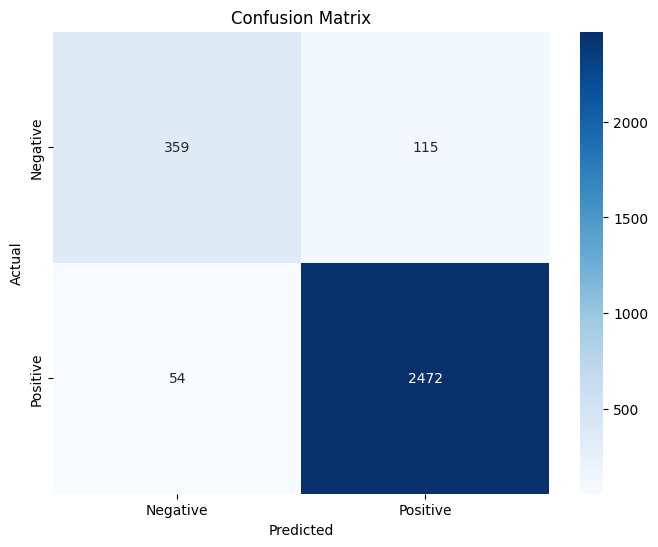

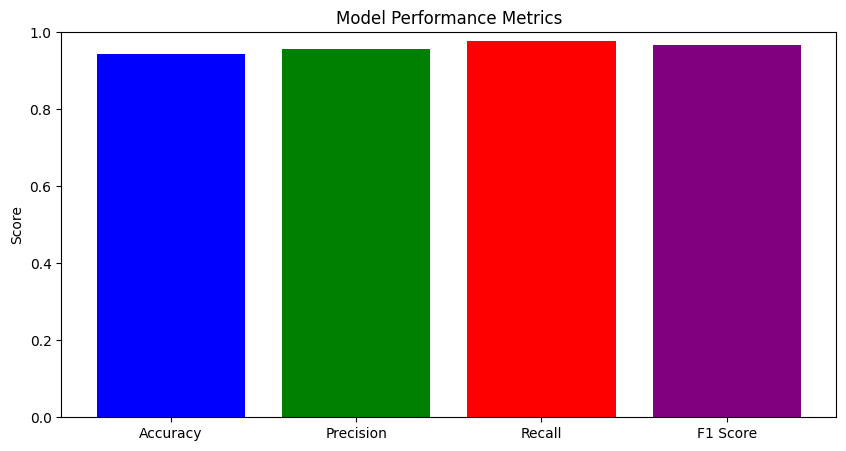

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot metrics
metrics = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
plt.figure(figsize=(10, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()